<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1703_feature_selection_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clustering Methods for Feature Selection

Clustering methods can be used for feature selection by identifying groups of similar features and selecting representative features from each cluster. These methods can help reduce redundancy and improve model interpretability. We'll explore three common clustering methods:

1. **K-Means Clustering**
2. **Hierarchical Clustering**
3. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

### Plan

#### 1. **K-Means Clustering**
- **Description**: K-Means is a partitioning method that divides the dataset into K clusters, where each cluster is represented by its centroid. The goal is to minimize the sum of squared distances between data points and their cluster centroids.
- **Feature Selection**:
  - Standardize the features to have zero mean and unit variance.
  - Apply K-Means clustering to the features.
  - Determine the optimal number of clusters using methods like the Elbow method or Silhouette analysis.
  - Select one representative feature from each cluster, such as the feature closest to the cluster centroid or the feature with the highest variance within the cluster.

#### 2. **Hierarchical Clustering**
- **Description**: Hierarchical Clustering is a method that builds a hierarchy of clusters by either merging smaller clusters into larger ones (agglomerative) or splitting larger clusters into smaller ones (divisive).
- **Feature Selection**:
  - Standardize the features.
  - Compute the distance matrix between features.
  - Apply hierarchical clustering using a linkage criterion (e.g., Ward's method).
  - Determine the optimal number of clusters by analyzing the dendrogram or using methods like the Silhouette score.
  - Select one representative feature from each cluster based on criteria like proximity to the cluster centroid or feature variance.

#### 3. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
- **Description**: DBSCAN is a density-based clustering method that groups together points that are closely packed and marks points in low-density regions as outliers. It does not require specifying the number of clusters in advance.
- **Feature Selection**:
  - Standardize the features.
  - Apply DBSCAN to the features, tuning parameters like the maximum distance between points (epsilon) and the minimum number of points required to form a dense region (min_samples).
  - Identify core samples and clusters formed by DBSCAN.
  - Select one representative feature from each cluster, such as the feature with the highest density or centrality within the cluster.

### Application and Use Cases
- **K-Means Clustering**:
  - **Use Case**: Suitable for datasets where you want to reduce feature redundancy and select a diverse set of features. Commonly used in customer segmentation, image compression, and text clustering.
  - **Example**: In customer segmentation, K-Means can be used to group similar purchasing behaviors and select representative features that describe each segment.

- **Hierarchical Clustering**:
  - **Use Case**: Ideal for understanding the hierarchical relationships between features and selecting representative features from nested clusters. Often used in gene expression analysis, social network analysis, and market research.
  - **Example**: In gene expression analysis, hierarchical clustering can group genes with similar expression patterns, and representative genes can be selected for further analysis.

- **DBSCAN**:
  - **Use Case**: Effective for identifying clusters of features in datasets with varying densities and noise. Commonly used in anomaly detection, spatial data analysis, and environmental data analysis.
  - **Example**: In anomaly detection, DBSCAN can identify clusters of normal behavior and select features that best represent these clusters while flagging outliers.

### Summary
Clustering methods provide a powerful approach for feature selection by leveraging the natural grouping of features. These methods can reduce redundancy, improve model interpretability, and provide insights into the relationships between features. By selecting representative features from each cluster, you can create a more compact and informative feature set for your machine learning models.



## K Means

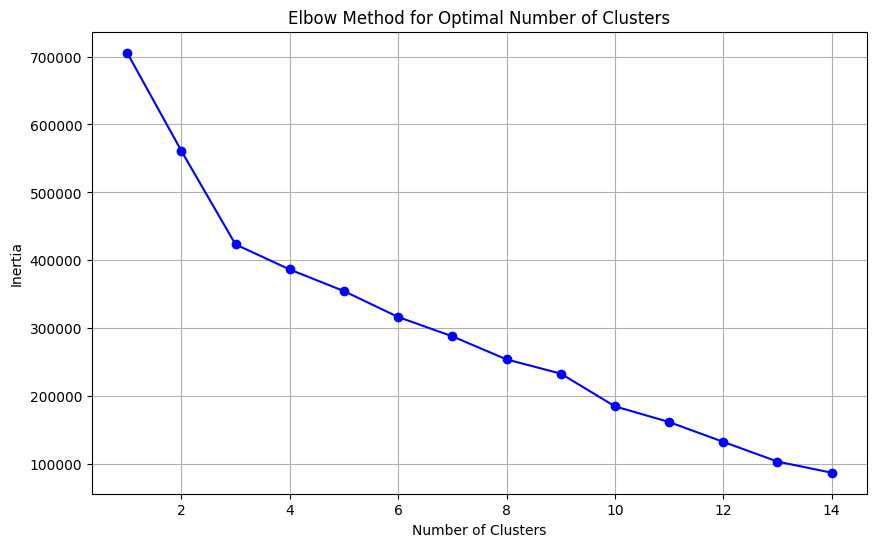

Selected features by K-Means Clustering: ['limit_bal', 'bill_amt1', 'pay_1', 'age', 'pay_amt1']
Classification Report (K-Means Clustering):
              precision    recall  f1-score   support

           0       0.91      0.11      0.19      4673
           1       0.23      0.96      0.38      1327

    accuracy                           0.29      6000
   macro avg       0.57      0.53      0.28      6000
weighted avg       0.76      0.29      0.23      6000



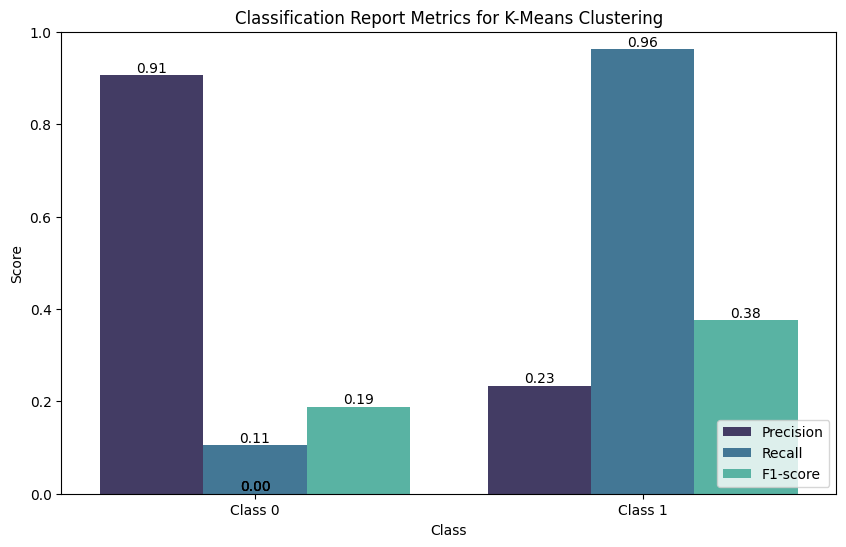

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_classification_report_metrics, plot_selected_features

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Standardize the features
preprocessor_kmeans = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

X_train_res_preprocessed = preprocessor_kmeans.fit_transform(X_train_res)

# Determine the optimal number of clusters using the Elbow method
inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_res_preprocessed.T)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Assuming the optimal number of clusters is determined from the Elbow plot (e.g., k=5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_train_res_preprocessed.T)
cluster_labels = kmeans.labels_

# Select representative features from each cluster
feature_names = numeric_features + list(preprocessor_kmeans.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
selected_features_kmeans = []

for cluster in range(optimal_k):
    cluster_features = np.where(cluster_labels == cluster)[0]
    closest_feature_idx = cluster_features[0]  # Select the first feature as representative (or implement another strategy)
    selected_features_kmeans.append(feature_names[closest_feature_idx])

print(f"Selected features by K-Means Clustering: {selected_features_kmeans}")

# Define a custom classifier to handle class-specific threshold
class ThresholdClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, threshold=0.3):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=3000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Train the model and evaluate with the selected features
X_train_selected = X_train_res[selected_features_kmeans]
X_test_selected = X_test[selected_features_kmeans]

pipeline_kmeans = Pipeline(steps=[
    ('classifier', classifier)
])

pipeline_kmeans.fit(X_train_selected, y_train_res)
y_pred_kmeans = pipeline_kmeans.predict(X_test_selected)
print("Classification Report (K-Means Clustering):")
print(classification_report(y_test, y_pred_kmeans))
classification_report_kmeans = classification_report(y_test, y_pred_kmeans, output_dict=True)

# Save the classification report
results = {}
results['K-Means Clustering'] = classification_report_kmeans

with open('classification_reports_clustering_methods.json', 'w') as f:
    json.dump(results, f, indent=4)

# Plot the classification report metrics
plot_classification_report_metrics(classification_report_kmeans, 'K-Means Clustering')


['limit_bal', 'bill_amt1', 'pay_1', 'age', 'pay_amt1']


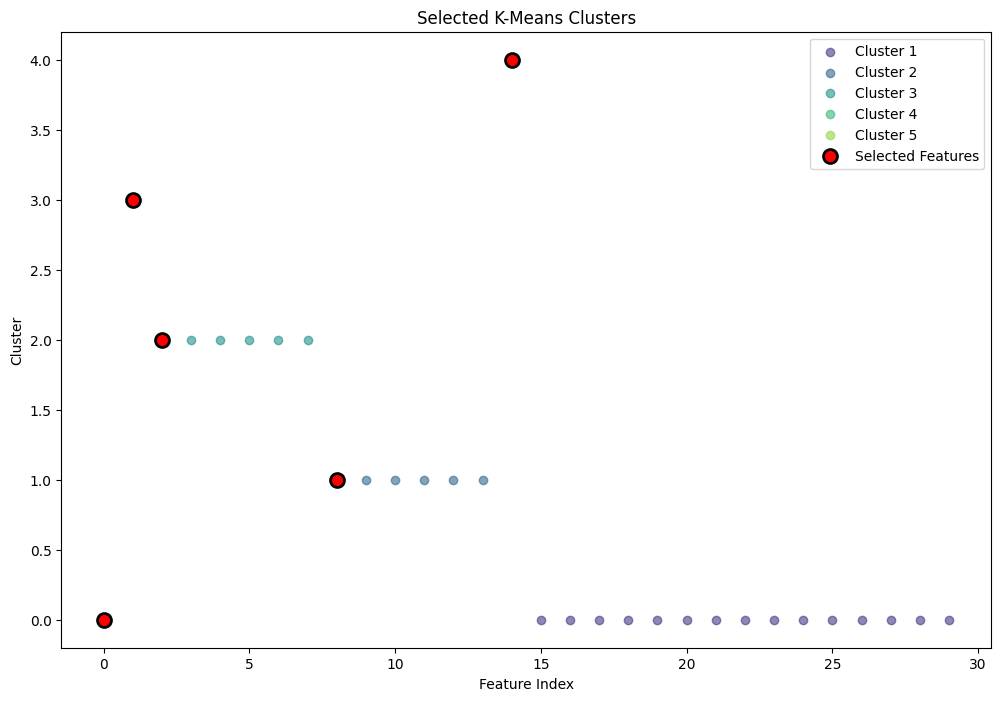

In [ ]:
print(selected_features_kmeans)

# Plotting the selected K-Means clusters
def plot_kmeans_clusters(X, feature_names, cluster_labels, selected_features, optimal_k):
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("viridis", optimal_k)

    for cluster in range(optimal_k):
        cluster_features = np.where(cluster_labels == cluster)[0]
        plt.scatter(cluster_features, [cluster] * len(cluster_features),
                    color=colors[cluster], label=f'Cluster {cluster+1}', alpha=0.6)

    # Highlight the selected features
    selected_indices = [feature_names.index(f) for f in selected_features]
    plt.scatter(selected_indices, [cluster_labels[i] for i in selected_indices],
                color='red', label='Selected Features', edgecolor='black', s=100, linewidth=2)

    plt.xlabel('Feature Index')
    plt.ylabel('Cluster')
    plt.title('Selected K-Means Clusters')
    plt.legend(loc='best')
    plt.show()

# Example usage
plot_kmeans_clusters(X_train_res_preprocessed.T, feature_names, cluster_labels, selected_features_kmeans, optimal_k)


## Hierarchical Clustering

#### preprocess

In [ ]:
# Preprocess the data
preprocessor_hc = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

X_train_res_preprocessed = preprocessor_hc.fit_transform(X_train_res)

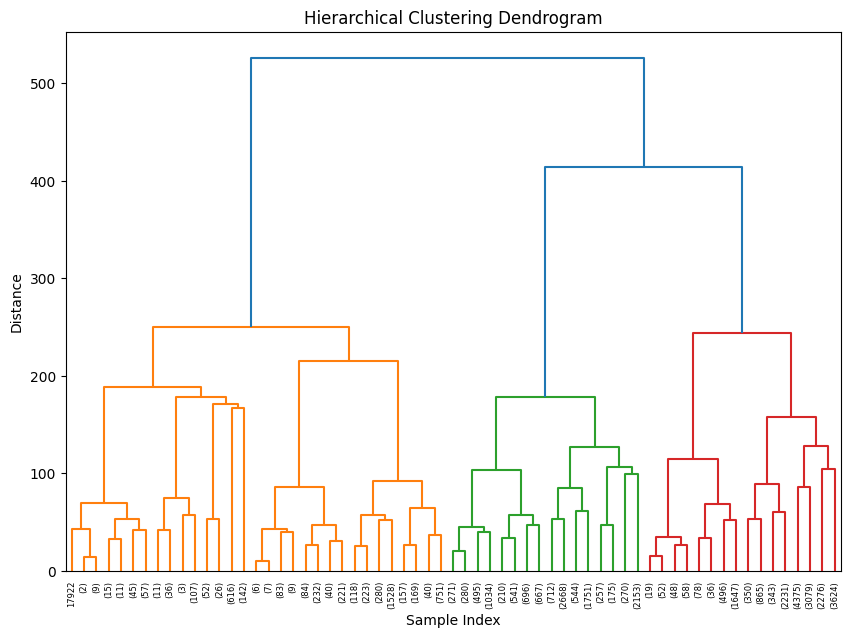

In [ ]:
# Compute the distance matrix and perform hierarchical clustering
Z = linkage(X_train_res_preprocessed, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


#### Determine the Optimal Number of Clusters:
To determine the optimal number of clusters, you can look for a "cut" on the dendrogram where the vertical distance is significant. This gap indicates where clusters are naturally separated.

In [ ]:
# Determine the optimal number of clusters by "cutting" the dendrogram
max_d = 100  # This is the distance at which you "cut" the dendrogram. Adjust this value based on the dendrogram plot.
clusters = fcluster(Z, max_d, criterion='distance')

# Add the cluster labels to the dataframe
X_train_res['cluster'] = clusters

# Check the number of clusters and their sizes
num_clusters = len(np.unique(clusters))
print(f"Number of clusters: {num_clusters}")
print(f"Cluster sizes:\n{pd.Series(clusters).value_counts().sort_index()}")

Number of clusters: 21
Cluster sizes:
1      140
2      157
3       78
4      236
5       43
6      337
7      141
8        1
9      682
10    3266
11    2080
12    2114
13    5675
14     432
15    2423
16     177
17    2257
18    3789
19    7454
20    2276
21    3624
Name: count, dtype: int64


#### Alternative Method - Inconsistency Method:
Another way to determine the number of clusters is by using the inconsistency method, which compares the height of each link with the average height of neighboring links.

In [ ]:
from scipy.cluster.hierarchy import inconsistent

# Compute inconsistency
depth = 5  # This is the depth of the hierarchy to compute inconsistency
incons = inconsistent(Z, depth)

# Use the inconsistency to decide on the number of clusters
threshold = 1.5  # Adjust based on the inconsistency statistics
clusters = fcluster(Z, t=threshold, criterion='inconsistent')

# Add the cluster labels to the dataframe
X_train_res['cluster'] = clusters

# Check the number of clusters and their sizes
num_clusters = len(np.unique(clusters))
print(f"Number of clusters: {num_clusters}")
print(f"Cluster sizes:\n{pd.Series(clusters).value_counts().sort_index()}")


Number of clusters: 1
Cluster sizes:
1    37382
Name: count, dtype: int64


#### Visualize the Clusters

In [ ]:
num_clusters

1

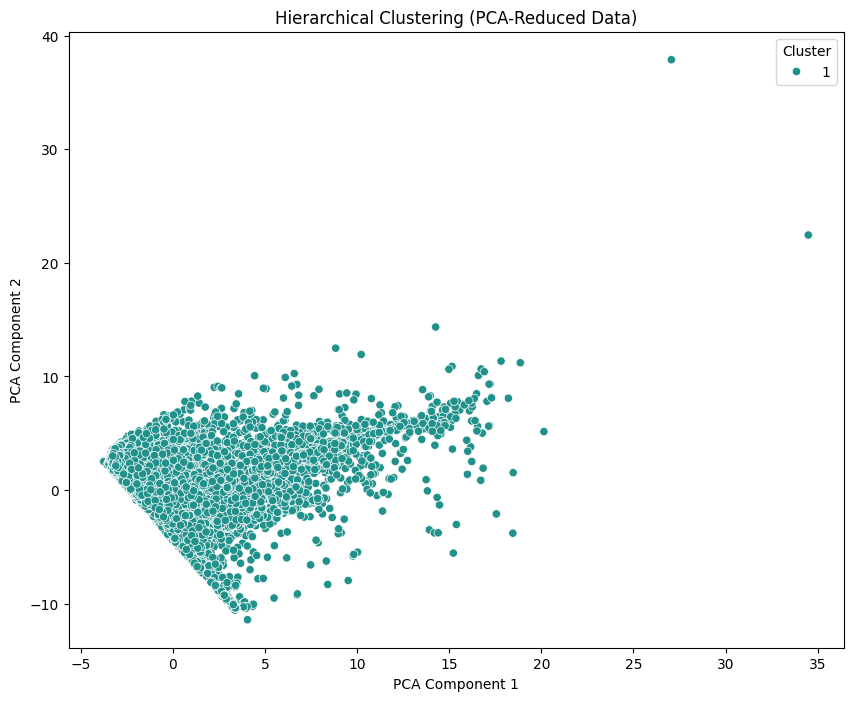

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_res_preprocessed)

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', legend='full')
plt.title('Hierarchical Clustering (PCA-Reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
# Save the dataframe with cluster labels
X_train_res.to_csv('X_train_with_hierarchical_clusters.csv', index=False)

## DBScan

#### Elbow Method for Epsilon

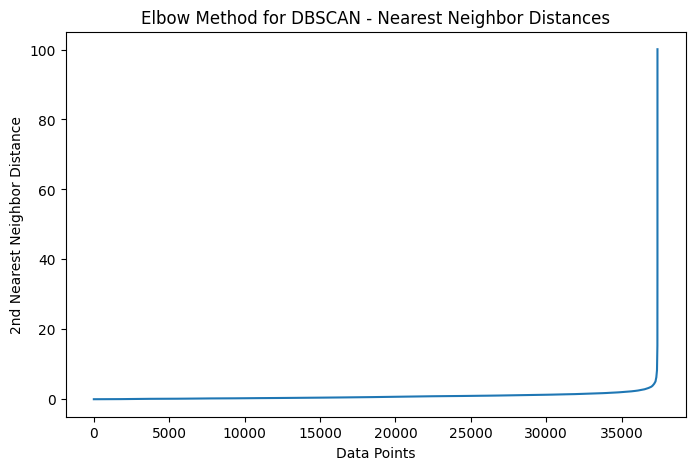

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Find the k-nearest neighbors (k=2 for DBSCAN)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_train_res_preprocessed)
distances, indices = nbrs.kneighbors(X_train_res_preprocessed)

# Sort distances and plot them
distances = np.sort(distances[:, 1], axis=0)
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('Elbow Method for DBSCAN - Nearest Neighbor Distances')
plt.xlabel('Data Points')
plt.ylabel('2nd Nearest Neighbor Distance')
plt.show()

# The "elbow" point in the plot suggests a good value for `eps`.

#### Grid Search for DBSCAN Parameters

In [ ]:
def dbscan_silhouette_score(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X)
    if len(np.unique(cluster_labels)) > 1:
        return silhouette_score(X, cluster_labels)
    else:
        return -1  # Invalid silhouette score if only one cluster

# Define the parameter grid
param_grid = {
    'eps': [0.5, 1.0, 1.5, 2.0],  # Adjust these based on your elbow plot
    'min_samples': [3, 5, 10]
}

# Perform a grid search manually
best_score = -1
best_params = None

for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:
        score = dbscan_silhouette_score(X_train_res_preprocessed, eps, min_samples)
        print(f"eps: {eps}, min_samples: {min_samples}, Silhouette Score: {score:.3f}")
        if score > best_score:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best Silhouette Score: {best_score:.3f} with params: {best_params}")


eps: 0.5, min_samples: 3, Silhouette Score: -0.408
eps: 0.5, min_samples: 5, Silhouette Score: -0.451
eps: 0.5, min_samples: 10, Silhouette Score: -0.444
eps: 1.0, min_samples: 3, Silhouette Score: -0.426
eps: 1.0, min_samples: 5, Silhouette Score: -0.413
eps: 1.0, min_samples: 10, Silhouette Score: -0.303
eps: 1.5, min_samples: 3, Silhouette Score: -0.398
eps: 1.5, min_samples: 5, Silhouette Score: -0.349
eps: 1.5, min_samples: 10, Silhouette Score: -0.170
eps: 2.0, min_samples: 3, Silhouette Score: -0.144
eps: 2.0, min_samples: 5, Silhouette Score: -0.003
eps: 2.0, min_samples: 10, Silhouette Score: 0.389
Best Silhouette Score: 0.389 with params: {'eps': 2.0, 'min_samples': 10}


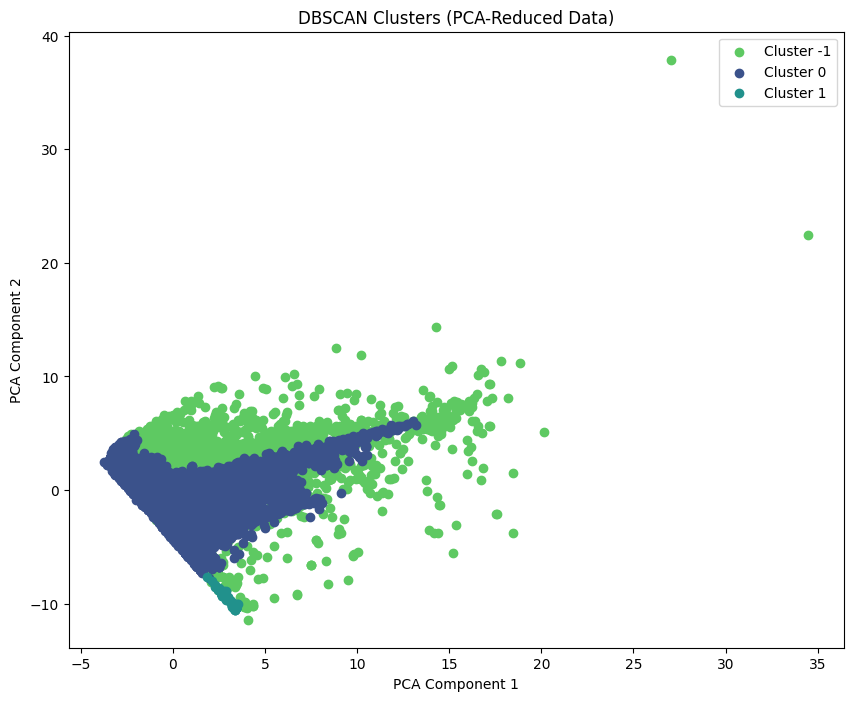

In [ ]:
# Apply DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
cluster_labels = dbscan.fit_predict(X_train_res_preprocessed)

# Add the cluster labels to the dataframe
X_train_res['cluster'] = cluster_labels

# Optionally, reduce dimensionality for plotting (e.g., using PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_res_preprocessed)

# Plot the clusters
plt.figure(figsize=(10, 8))
unique_clusters = np.unique(cluster_labels)
colors = sns.color_palette('viridis', len(unique_clusters))

for cluster in unique_clusters:
    plt.scatter(X_pca[cluster_labels == cluster, 0], X_pca[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}', color=colors[cluster])

plt.title('DBSCAN Clusters (PCA-Reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Save the dataframe with cluster labels
X_train_res.to_csv('X_train_with_clusters.csv', index=False)


####  Silhouette Score:
The Silhouette Score is a measure of how similar an object is to its own cluster compared to other clusters. For DBSCAN, you can calculate the Silhouette Score to get an idea of the quality of the clustering.

A higher Silhouette Score indicates better-defined clusters. You can experiment with different values of eps and min_samples to maximize this score.

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
if len(np.unique(cluster_labels)) > 1:  # Check if more than one cluster exists
    silhouette_avg = silhouette_score(X_train_res_preprocessed, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.3f}")
else:
    print("Not enough clusters to calculate silhouette score.")


Silhouette Score: 0.389


#### Loan Data Utils

In [ ]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


# #--------   Plot Classification Report  --------#

# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

def plot_classification_report_thresholds(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

# #--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
